# 10. CHICAGO AIRBNB: MODEL TUNING

## 1. Recap

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
pd.set_option("display.max_columns", 99)
pd.set_option("display.max_rows", 999)
pd.set_option('precision', 3)

chicago = pd.read_csv('data/chicago_airbnb3')

num_cols = ['host_rr', 'host_ar', 'latitude', 'longitude', 'accommodates',
            'baths', 'bedrooms', 'beds', 'min_nights', 'max_nights', 'n_reviews', 
            'rs_rating', 'rs_accuracy', 'rs_cleanliness', 'rs_check_in', 
            'rs_communication', 'rs_location', 'rs_value', 'reviews_per_month']

cat_cols = ['host_rt', 'neighborhood', 'property_type', 'room_type']

train, test = train_test_split(chicago, test_size=0.2, random_state=42)

X_train = train.drop('price', axis=1)
y_train = train['price']

X_test = test.drop('price', axis=1)
y_test = test['price']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5240, 25), (5240,), (1310, 25), (1310,))

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

class AttributeAdder(BaseEstimator, TransformerMixin):    
    def __init__(self):
        self    
        
    def fit(self, df, y = None):               
        return self

    def transform(self, df):        
        df_ = df.copy()
        df_['beds_per_bdrm'] = df_['beds']/df_['bedrooms']
        df_['baths_per_bed'] = df_['baths']/df_['beds']
        df_.replace(np.inf, 0, inplace=True)
        df_.replace(np.nan, 0, inplace=True)
        return df_
    
num_pipe = Pipeline(steps = [
    ('add_features', AttributeAdder()),
    ('std_scaling', StandardScaler())
])
full_pipe = ColumnTransformer(
    transformers=[
        ('num_prep', num_pipe, num_cols),
        ('cat_prep', OneHotEncoder(sparse=False), cat_cols)
    ])

X_train = full_pipe.fit_transform(X_train)
X_test = full_pipe.transform(X_test)

X_train.shape, X_test.shape

((5240, 93), (1310, 93))

In [3]:
model_df = pd.read_csv('data/chicago_airbnb4_models')
model_df.columns = ['RMSE', 'OLS_LR_all', 'OLS_LR_36', 'ElasNet_36', 
                    'KNN_all', 'RandFor_all']
model_df

,RMSE,OLS_LR_all,OLS_LR_36,ElasNet_36,KNN_all,RandFor_all
0,rmse_1,425.931,552.859,552.819,417.219,422.306
1,rmse_2,183.527,210.802,210.359,185.514,184.979
2,rmse_3,134.728,123.628,118.106,123.416,134.961
3,rmse_4,138.456,128.244,123.103,135.151,136.021
4,rmse_5,413.153,590.703,590.501,419.743,421.211
5,rmse_6,447.291,463.421,461.630,450.736,449.103
6,rmse_7,568.169,143.516,138.461,566.424,572.348
7,rmse_8,140.921,123.251,119.284,134.056,150.106
8,rmse_9,444.477,129.995,123.141,442.413,447.136
9,rmse_10,130.011,412.477,412.350,113.691,114.374


## 2. Reducing Features Using Principal Components
We want to reduce the number of features while retaining the variance in the data

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, whiten=True)
X_train_pca = pca.fit_transform(X_train)

print("Original number of features:", X_train.shape[1])
print("Reduced number of features:", X_train_pca.shape[1])

Original number of features: 93
Reduced number of features: 26


The output of our solution shows that PCA let us reduce our dimensionality by a wopping 67 (72%) features while still retaining 95% of the information (variance) in the feature matrix.

In [5]:
pca.explained_variance_

array([4.64938613, 3.48702325, 2.07064037, 1.51684252, 1.34904604,
       1.15115221, 1.09107001, 0.91861542, 0.84215224, 0.75376112,
       0.71785418, 0.56043914, 0.43234613, 0.38420376, 0.3724925 ,
       0.31875881, 0.3071287 , 0.28155298, 0.26640015, 0.22223678,
       0.1734344 , 0.16193853, 0.14135618, 0.13142378, 0.12928797,
       0.09760897])

## 3. Plotting PCA's Explained Variance

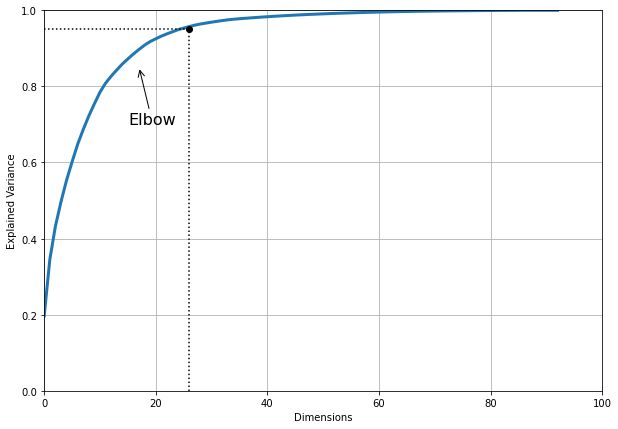

In [6]:
import matplotlib.pyplot as plt

pca_1 = PCA()
pca_1.fit(X_train)
cumsum = np.cumsum(pca_1.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

plt.figure(figsize=(10,7))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 100, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(17, 0.85), xytext=(15, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

## 4. Training Models after PCA

In [8]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

knn_model = Pipeline([
    ('pca', PCA(n_components=0.95, whiten=True)),
    ('knn', KNeighborsRegressor())
])
kpar = {'knn__n_neighbors': np.arange(1, 21, 2),
       'knn__weights': ['uniform', 'distance'],
       'knn__algorithm': ['ball_tree', 'kd_tree', 'brute'],
       'knn__p': [1,2]
      }
kgrid = GridSearchCV(knn_model, kpar, n_jobs=-1, cv=10)
kgrid.fit(X_train, y_train)     

print('Best Parameters:', kgrid.best_params_)
print('Best Score:', kgrid.best_score_)

Best Parameters: {'knn__algorithm': 'ball_tree', 'knn__n_neighbors': 19, 'knn__p': 1, 'knn__weights': 'uniform'}
Best Score: 0.1285674892499459


In [10]:
from sklearn.model_selection import cross_val_score

knn_model = Pipeline([
    ('pca', PCA(n_components=0.95, whiten=True)),
    ('knn', KNeighborsRegressor(algorithm='ball_tree', 
                                n_neighbors=19,
                                p=1, 
                                weights='uniform'))
])
knn_mse = cross_val_score(knn_model, X_train, y_train, cv=10, n_jobs=-1, 
                             scoring="neg_mean_squared_error") 
knn_rmse = np.sqrt(np.absolute(knn_mse))
print('RMSE:', knn_rmse)
print('Avg_RMSE:', knn_rmse.mean())
print('Std_RMSE:', knn_rmse.std())

RMSE: [438.55526927 188.60044533 127.74280555 146.01301654 420.36460747
 446.4599752  568.93278988 143.56518896 444.51846024 124.2923112 ]
Avg_RMSE: 304.904486963505
Std_RMSE: 164.08688293576697
